In [87]:
import os 
import sys
import pandas as pd
import numpy as np
sys.path.insert(0, "..")
from PIL import Image
import matplotlib.pyplot as plt

In [135]:
lap_path = "../../data/appa-real-release"
train_csv = os.path.join(lap_path, "gt_train.csv")
valid_csv = os.path.join(lap_path, "gt_valid.csv")
test_csv = os.path.join(lap_path, "gt_test.csv")

new_train_csv = os.path.join(lap_path, "train.csv")
new_valid_csv = os.path.join(lap_path, "valid.csv")
new_test_csv = os.path.join(lap_path, "test.csv")




In [94]:
train_path = os.path.join(lap_path, "train")


In [118]:
os.listdir(lap_path)

['gt_avg_valid.csv',
 'train.csv',
 'train',
 'test.csv',
 'gt_train.csv',
 '.badfiles.un~',
 'test',
 'gt_valid.csv',
 'README.txt',
 '.README.txt.un~',
 '.parse_labels.m.un~',
 'valid',
 'gt_test.csv',
 'valid.csv',
 'gt_avg_test.csv',
 '.clean_asdf.sh.un~',
 'gt_avg_train.csv']

In [48]:
os.listdir(lap_path)

['gt_avg_valid.csv',
 'train',
 'gt_train.csv',
 '.badfiles.un~',
 'test',
 'gt_valid.csv',
 'README.txt',
 '.README.txt.un~',
 '.parse_labels.m.un~',
 'valid',
 'gt_test.csv',
 'gt_avg_test.csv',
 '.clean_asdf.sh.un~',
 'gt_avg_train.csv']

In [35]:
import re

In [46]:
train_path.split("gt_")

['../../data/appa-real-release/train']

In [49]:
train_type = train_csv.split("gt_")[1].split(".csv")[0]

In [50]:
train_type

'train'

In [132]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import cv2
from PIL import Image
import dlib
import pandas as pd
from transformers import ViTConfig, ViTModel, ViTFeatureExtractor
import torch.nn as nn
import os
from utils import generate_masks


class FaceAgeDataset(Dataset):
    def __init__(
        self,
        csv_path,
        data_dir="/home/jessekim/",
        transform=None,
        mask_info="BOX",
        data_source="wiki",
    ):
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        self.data_dir = data_dir
        shape_predictor_path = os.path.join(
            data_dir, "models", "shape_predictor_68_face_landmarks.dat"
        )
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(shape_predictor_path)

        self.transform = transform
        self.mask_info = mask_info
        self.data_source = data_source
        print(self.data_source)

        ## VIT constants
        self.IMAGE_SIZE = 224  # 384 #224
        self.N_LABELS = 99  # 1 to 99 but subtract 1 so 0 to 98

        # transformations:
        #         self.preprocess_mask = transforms.Compose([
        #             transforms.Resize((self.IMAGE_SIZE, self.IMAGE_SIZE)),
        #             transforms.ToTensor()])

        norm = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

        self.feature_extractor = ViTFeatureExtractor.from_pretrained(
            'google/vit-base-patch16-224-in21k'
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        print(idx)
        # get specific example:
        sample = self.df.iloc[idx]


        if self.data_source == "wiki":
            img_path = os.path.join(
                self.data_dir, "data", "wiki_crop", sample["full_path"]
            )
        elif self.data_source == "lap":
            #should be train, valid or test
            train_type = self.csv_path.split(".csv")[0]

            img_path = os.path.join(
                self.data_dir, "data", "appa-real-release", train_type, sample["full_path"]
            )
        else:
            img_path = os.path.join(self.data_dir, "data", sample["full_path"])

        img = Image.open(img_path)
        tensor_img = transforms.ToTensor()(img)
        ### IMAGE CHANNEL/SIZE CONVERSIONS TO GET 3 CHANNEL IMAGES ##

        # convert to RGB
        if (len(tensor_img.shape) < 3) | (tensor_img.shape[0] != 3):  # if not RGB:
            img = img.convert("RGB")

        regions = False
        box = False

        if self.mask_info == "BOX":
            box = True
        elif self.mask_info == "5CHANNEL":
            regions = True

        # generate normalized and resized image:
        processed_img = self.feature_extractor(img)["pixel_values"][0]
        transformed_img = torch.tensor(processed_img)

        # generate masks
        mask = generate_masks(
            img_path, self.predictor, self.detector, regions=regions, box=box
        )
        transformed_mask = cv2.resize(mask, dsize=(self.IMAGE_SIZE, self.IMAGE_SIZE))
        transformed_mask = torch.tensor(transformed_mask)
        if len(transformed_mask.shape) < 3:
            transformed_mask = transformed_mask.unsqueeze(-1)

        # get label:
        label = (
            sample["age"] - 1
        )  # need to subtract one since need to fit in possible values!! #want to get label to be between 0 and 1 (normalize label)


        return transformed_img, label, transformed_mask 


In [136]:
lap_dataset = FaceAgeDataset(csv_path = new_train_csv, data_source="lap")
lap_dataset.__len__()

lap


4113

In [137]:
lap_dataset[0]

0


(tensor([[[ 0.0118,  0.0902,  0.2471,  ...,  0.2314,  0.2392,  0.2392],
          [ 0.0196,  0.0980,  0.2392,  ...,  0.2549,  0.2627,  0.2627],
          [ 0.0353,  0.1059,  0.2235,  ...,  0.3020,  0.3020,  0.3020],
          ...,
          [-0.0980, -0.1294, -0.1843,  ...,  0.5216,  0.5451,  0.5608],
          [-0.1059, -0.1373, -0.1922,  ...,  0.5216,  0.5451,  0.5608],
          [-0.1137, -0.1451, -0.2000,  ...,  0.5216,  0.5451,  0.5608]],
 
         [[-0.4510, -0.3647, -0.2000,  ..., -0.1373, -0.1294, -0.1294],
          [-0.4353, -0.3569, -0.2078,  ..., -0.1059, -0.1059, -0.1059],
          [-0.4118, -0.3412, -0.2157,  ..., -0.0510, -0.0510, -0.0510],
          ...,
          [-0.4196, -0.4510, -0.5059,  ...,  0.0745,  0.0980,  0.1137],
          [-0.4275, -0.4588, -0.5137,  ...,  0.0745,  0.0980,  0.1137],
          [-0.4353, -0.4667, -0.5216,  ...,  0.0745,  0.0980,  0.1137]],
 
         [[-0.7176, -0.6314, -0.4667,  ..., -0.2627, -0.2549, -0.2549],
          [-0.7020, -0.6235,

In [123]:
from utils import load_in_model

In [127]:
exp_name = "DenseNet_NLL_NOMASK_0DROP.csv"

In [129]:
os.path.join( "/home/jessekim/logs", exp_name)

'/home/jessekim/logs/DenseNet_NLL_NOMASK_0DROP.csv'

In [146]:
tracker_csv_path = os.path.join( "/home/jessekim/logs", "exp_tracker_1.csv")

In [147]:
pd.read_csv(tracker_csv_path)

,date,model_dir,log_csv_path,logs_dir,seed,train_data,exp_name,bs,shuffle,patience_limit,num_epochs,lr,num_workers,device,model_type,load_model,loss_type,optimizer_type,scheduler_type,output_type
0,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_1CHANNEL_postmask,16,1,10,250,0.001000,4,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
1,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_1CHANNEL_premask,16,1,10,250,0.001000,1,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
2,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_5CHANNEL_premask,16,1,10,250,0.001000,4,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
3,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_5CHANNEL_premask,16,1,10,250,0.001000,4,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
4,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_5CHANNEL_premask,16,1,10,250,0.001000,4,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
5,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_5CHANNEL_premask,16,1,10,250,0.001000,4,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
6,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_5CHANNEL_premask,16,1,10,250,0.001000,8,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
7,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_5CHANNEL_premask,16,1,10,250,0.001000,8,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
8,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_5CHANNEL_postmask,16,1,10,250,0.001000,8,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification
9,11/27/21,/home/jessekim/models/,/home/jessekim/logs/exp_tracker.csv,/home/jessekim/logs,42,train,VIT_NLL_BOX_premask,16,1,10,250,0.001000,4,cuda,AlteredVIT,NaN,NLL,adam,cosine,classification


In [ ]:
load_in_model()

In [ ]:
lap_path = "../../data/appa-real-release"
train_csv = os.path.join(lap_path, "gt_train.csv")
valid_csv = os.path.join(lap_path, "gt_valid.csv")
test_csv = os.path.join(lap_path, "gt_test.csv")

In [ ]:

# def model_eval(experiment_name):

#     test_dataloader = create_datasets(create_datasets="test", mask_info=mask_info, bs=bs, shuffle=True, num_workers=num_workers,  data_source=data_source)

#     model, test_loss_vals, test_mae_vals, test_acc = run_one_epoch(model, test_loader, optimizer=None, mask_info, scheduler, loss, train=False, device=device, output_type=output_type, loss_type=loss_type)

In [88]:
im, lab, mask = lap_dataset[0]

0


In [85]:
im.shape

torch.Size([3, 224, 224])

In [91]:
lab

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


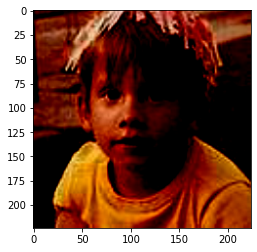

In [90]:
plt.imshow(im.permute(1,2,0))

In [100]:
gt_train = pd.read_csv(os.path.join(lap_path, "gt_train.csv"))

In [101]:
gt_train

,file_name,real_age,apparent_age,worker_age,worker_gender
0,000000.jpg,4,5,36,male
1,000000.jpg,4,4,38,female
2,000000.jpg,4,7,52,female
3,000000.jpg,4,5,50,male
4,000000.jpg,4,4,52,female
...,...,...,...,...,...
133930,004112.jpg,20,17,-1,NaN
133931,004112.jpg,20,20,26,NaN
133932,004112.jpg,20,22,31,NaN
133933,004112.jpg,20,19,19,NaN


In [119]:
def convert_csvs(csv_path):
    df = pd.read_csv(csv_path)
    df = df.groupby("file_name").mean()["real_age"].reset_index()
    df["file_name"] = df["file_name"] + "_face.jpg"
    df.columns = ["full_path", "age"]
    return df.reset_index(drop=True)

In [131]:
convert_csvs(train_csv)

,full_path,age
0,000000.jpg_face.jpg,4.0
1,000001.jpg_face.jpg,18.0
2,000002.jpg_face.jpg,80.0
3,000003.jpg_face.jpg,50.0
4,000004.jpg_face.jpg,17.0
...,...,...
4108,004108.jpg_face.jpg,41.0
4109,004109.jpg_face.jpg,53.0
4110,004110.jpg_face.jpg,35.0
4111,004111.jpg_face.jpg,28.0


In [120]:
convert_csvs(train_csv).to_csv(os.path.join(lap_path, "train.csv"))
convert_csvs(valid_csv).to_csv(os.path.join(lap_path, "valid.csv"))
convert_csvs(test_csv).to_csv(os.path.join(lap_path, "test.csv"))

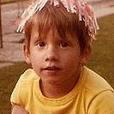

In [81]:
Image.open(os.path.join(train_path, faces[0]))

In [26]:
faces = sorted([i for i in os.listdir(os.path.join(lap_path, "train")) if ".jpg_face.jpg" in i ])